This notebook grades transfer survey questions and runs descriptive analysis on these grades to inform future analysis.

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is converted to HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from tabulate import tabulate
from __future__ import division  #needed for eval to divide fractions to float instead of integer default of Python v<3
from utils_read_parsing import *

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 10,4
CMAP = ['cornflowerblue','#fc8d62','#a6d854','#b3b3b3','#e78ac3','#66c2a5','#ffd92f']
matplotlib.rcParams['axes.color_cycle'] = CMAP
plt.style.use = 'default'
plt.rcParams['figure.figsize'] = (8, 6)
pd.options.display.max_columns = 999

d:\applications\anaconda2\lib\site-packages\matplotlib\__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Import files

Loading post survey data.

In [3]:
try:
    posts = pd.read_csv('post_survey_results.txt', sep='\t')
except:
    raise Exception("Try running the notebook data_log_to_pre_post_surveys_connector.ipynb and then run this cell again.")
posts.replace('Absorbance','L',inplace=True)
posts.replace('Capacitance','C',inplace=True)

Adding student activity order to dataframe

In [4]:
metadf = get_student_metadata()
order = dict(zip(metadf.index,metadf['activity order']))
posts['activity order'] = posts['sid'].apply(lambda sid: order[sid])

In [5]:
posts.head(2)

,Unnamed: 0,age,debug1,debug2,english.0-writing,english.1-reading,[gender] To which gender do you most identify? [Gender non conforming/non-binary],[gender] To which gender do you most identify? [Man],[gender] To which gender do you most identify? [Prefer not to answer],gender-Woman,original id,major,open1,open2,perceivedvalue.0-boring,perceivedvalue.1-productive,perceivedvalue.2-useless,perceivedvalue.3-engaging,pocc.0-learning the basic concepts,pocc.1-testing my ideas and theories,pocc.2-answering given questions,pocc.3-memorizing key information,pocc.4-exploring the topic,qual2,qual3,qual4,qual5,qual5reasoning,qual6,qual6reasoning,quant.0,quant.0.1,quant.1,quant.1.1,quant.2,quant.2.1,quant.3,quant.3.1,strategies.0-setup my first experiment right away,strategies.10-try to identify mathematical relationships,strategies.11-try to apply my prior knowledge of physics,strategies.12-predict the result of a test before trying something out,strategies.13-decide what to investigate based on previous results,strategies.14-identify what I haven't investigated yet,strategies.1-spend time designing a set of experiments I want to conduct,strategies.2-make a plan,strategies.3-explore the different components of the PhET interface,strategies.4-identify important variables,strategies.5-look for weird outcomes I did not expect,strategies.6-look for general patterns and then dive into detailed experimentation,strategies.7-check if the relationships I found hold under different conditions,strategies.8-think about why I get the results I get,strategies.9-summarize my findings as I go,strategies_att.0-try to get the right answer,strategies_att.1-improve my scientific reasoning skill,strategies_att.2-try to learn more about the topic,strategies_att.3-finish as quickly as possible,strategies_att.4-come up with my own questions to investigate,taskinterpretation.0-investigate the basic mechanics of the topic at hand,taskinterpretation.1-design my own experiments that can help me understand the topic at hand,taskinterpretation.2-memorize information about the topic at hand,taskinterpretation.3-complete a certain number of questions,taskinterpretation.4-develop scientific reasoning skills,[year] What year are you in? [1st year undergraduate],[year] What year are you in? [2nd year undergraduate],[year] What year are you in? [3rd year undergraduate],[year] What year are you in? [4th year undergraduate],sim,sim_index,qual1,sid,activity order
0,2,18-19,"Based on virtual lab results, the charge vs. p...",The negative should not be there because it on...,Fluent,Fluent,NaN,NaN,NaN,1.0,77047160,*Non science or applied science major,I conducted 4 different experiments where I va...,Graphs helped visualize the patterns. Next tim...,Somewhat,Mostly,Not at all,Mostly,Often,Almost always,Almost always,Often,Often,higher voltage battery (https://survey.ubc.ca/...,(https://survey.ubc.ca/media/assets/user/2316...,smaller separation (https://survey.ubc.ca/medi...,(https://survey.ubc.ca/media/assets/user/2316...,The magnitude of the voltage is increasing in ...,two large plates perfectly aligned (https://su...,The plates need to be aligned perfectly in ord...,NaN,0.5,NaN,0.25,NaN,2,NaN,08-Jan,Mostly,Definitely,Somewhat,Mostly,Mostly,Mostly,Mostly,Somewhat,Mostly,Somewhat,Definitely,Mostly,Definitely,Definitely,Definitely,Definitely,Mostly,Somewhat,Somewhat,Mostly,Mostly,Mostly,Somewhat,Mostly,Mostly,1.0,NaN,NaN,NaN,C,2,larger plates (https://survey.ubc.ca/media/ass...,77047160,LC
1,3,20-22,"k1, k2, and k3 are unnecessary. There should b...","s^2 should be s, as Q is inversely proportiona...",Average,Fluent,NaN,1.0,NaN,NaN,90447168,*Undeclared,I tried to explore more different combinations...,I believe I managed to find all the possible o...,Not at all,Mostly,Not at all,Mostly,Almost always,Often,Almost always,Almost always,Often,higher voltage battery (https://survey.ubc.ca/...,(https://survey.ubc.ca/media/assets/user/2316...,smaller separation (https://survey.ubc.ca/m

Loading answerkey for quantitative and qualitative transfer questions

In [6]:
df_ans = pd.read_csv('all_quant_answers_key.csv', delimiter=',')
qual_colnames = [c for c in set(df_ans['question']) if 'qual' in c]
quant_L_colnames = [c for c in set(df_ans[df_ans['sim']=='L']['question']) if 'quant' in c]
quant_C_colnames = [c for c in set(df_ans[df_ans['sim']=='C']['question']) if 'quant' in c]
df_ans.head()

,sim,question,answer,score
0,L,quant.0,0,0
1,L,quant.1,0,0
2,L,quant.2,0,0
3,L,quant.3,0,0
4,C,quant.3.1,0,0


# Grade questions

## The grader

In [7]:
def grade_questions( df, df_ans, sim, questions,  id_header ):
    students = df[id_header]
    for question in questions:
        for student in students:
            idx = df[(df[id_header]==student)&(df['sim']==sim)].index.tolist()[0]
            student_ans = df.loc[idx][question]
#             if "Jan" in student_ans:
#                 student_ans = '1/' + student_ans[1]
#                 print student_ans
            try:
                score = df_ans.get_value(df_ans[(df_ans['answer']==student_ans)&(df_ans['question']==question)&(df_ans['sim']==sim)].index.tolist()[0],'score')
                df.set_value(idx, "{0}_{1}_score".format(question, sim), score)
            except:
                print "Couldn't find grarde for:", sim, student, student_ans, question

In [8]:
grade_questions(posts, df_ans, 'L', quant_L_colnames, 'sid')
grade_questions(posts, df_ans, 'C', quant_C_colnames, 'sid')

In [9]:
grade_questions(posts, df_ans, 'L', qual_colnames, 'sid')
grade_questions(posts, df_ans, 'C', qual_colnames, 'sid')

## Renaming columns to facilitate analysis

### For qualitative questions

In [10]:
#We can rename questions given what we know about them
new_col_names = {'qual1_L_score':'qual1_L_near_concentration',
                    'qual2_L_score':'qual2_L_far_volume',
                    'qual3_L_score':'qual3_L_near_width',
                    'qual4_L_score':'qual4_L_near_detector',
                    'qual5_L_score':'qual5_L_far_laserangle',
                    'qual6_L_score':'qual6_L_near_wavelength',
                    'qual1_C_score':'qual1_C_near_area',
                    'qual2_C_score':'qual2_C_near_voltage',
                    'qual3_C_score':'qual3_C_far_areazerovoltage',
                    'qual4_C_score':'qual4_C_near_separation',
                    'qual5_C_score':'qual5_C_near_polarvoltage',
                    'qual6_C_score':'qual6_C_far_offset',
                    'quant.0.1_C_score': 'quant.0.1_C_near_area',
                    'quant.1.1_C_score': 'quant.1.1_C_near_separation',
                    'quant.2.1_C_score': 'quant.2.1_C_interaction_equal',
                    'quant.3.1_C_score': 'quant.3.1_C_interaction_quadruple',
                    'quant.0_L_score': 'quant.0_L_near_width',
                    'quant.1_L_score': 'quant.1_L_near_concentration',
                    'quant.2_L_score': 'quant.2_L_interaction_quadruple',
                    'quant.3_L_score': 'quant.3_L_interaction_equal'}

posts.rename(index=str,columns=new_col_names,inplace=True)

Right now the qual questions  look like this:
```
sid     sim    qual1_L_     qual1_C_
123      L         1            NaN       
123      C        NaN            2
```

We transform them so they look like:
```
sid     qual1_L_     qual1_C_
123       1            2
```

In [11]:
qual_score_columns = ['qual1_L_near_concentration', #near transfer absorbance
                      'qual3_L_near_width',
                      'qual4_L_near_detector',
                      'qual6_L_near_wavelength',
                      #
                      'qual4_C_near_separation', #near transfer capacitance
                      'qual1_C_near_area',
                      'qual2_C_near_voltage',
                      'qual5_C_near_polarvoltage',
                      #
                      'qual5_L_far_laserangle', #far transfer
                      'qual2_L_far_volume',
                      'qual3_C_far_areazerovoltage',
                      'qual6_C_far_offset']

posts_L = posts[[col for col in qual_score_columns if 'L' in col]+['sid','activity order']].dropna()
posts_L.index = posts_L['sid']
posts_C = posts[[col for col in qual_score_columns if 'C' in col]+['sid']].dropna()
posts_C.index = posts_C['sid']
posts_C.drop(['sid'],axis=1,inplace=True)
qual_scores = pd.concat([posts_C,posts_L],join='inner',axis=1)
qual_scores.reset_index(drop=True);

### For quantitative questions

In [12]:
quant_scores_ordinal = posts[[col for col in posts.columns if 'quant' in col and ('_L_' in col or '_C_' in col)]]
quant_scores_ordinal.shape

(296, 8)

We do the same transformation as above for quant scores

In [13]:
quant_score_columns = ['quant.0.1_C_near_area', #near absorbance
                    'quant.1.1_C_near_separation',
                    'quant.2.1_C_interaction_equal', #interaction absorbance
                    'quant.3.1_C_interaction_quadruple',
                    'quant.0_L_near_width', #near capacitance
                    'quant.1_L_near_concentration',
                    'quant.2_L_interaction_quadruple', #interaction capacitance
                    'quant.3_L_interaction_equal']

posts_L = posts[[col for col in quant_score_columns if 'L' in col]+['sid','activity order']].dropna()
posts_L.index = posts_L['sid']
posts_C = posts[[col for col in quant_score_columns if 'C' in col]+['sid']].dropna()
posts_C.index = posts_C['sid']
posts_C.drop(['sid'],axis=1,inplace=True)
quant_scores_ordinal = pd.concat([posts_C,posts_L],join='inner',axis=1)
quant_scores_ordinal.reset_index(drop=True);

# Descriptive analysis

## Qualitative grades

### Distribution

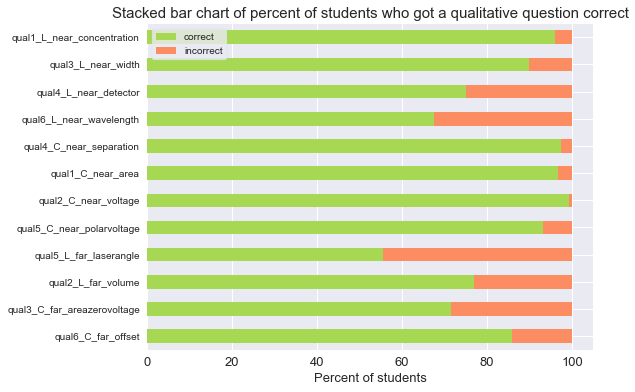

In [14]:
CMAP = ['#a6d854','#fc8d62','#e78ac3','#66c2a5','#ffd92f']
matplotlib.rcParams['axes.color_cycle'] = CMAP
qual_scores[qual_score_columns].apply(lambda x: x.value_counts()).transpose().iloc[::-1,:].plot.barh(stacked=True)
ax = plt.subplot()
ax.legend(loc=2,frameon=True,labels=['correct','incorrect']);ax.set_xlabel('Percent of students',fontsize=13)
ax.set_xticklabels([0,20,40,60,80,100],fontsize=13)
ax.set_xticks([round(int(x)*148.0/100.0,1) for x in [0,20,40,60,80,100]])
ax.set_title("Stacked bar chart of percent of students who got a qualitative question correct",fontsize=15);

### Correlation between question pairs

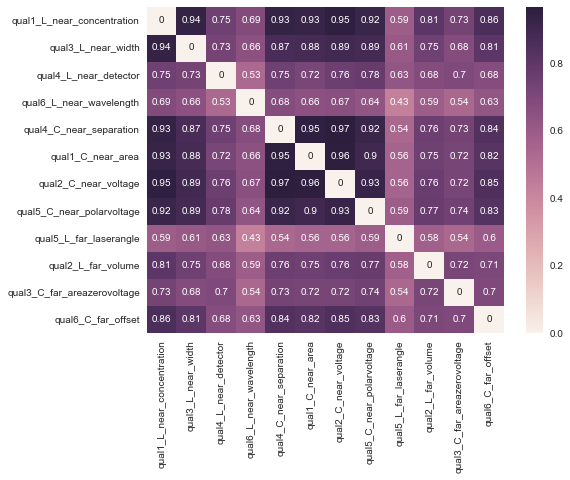

In [15]:
from scipy.stats import spearmanr
from sklearn.metrics import jaccard_similarity_score
correlation_matrix = np.zeros((len(qual_score_columns),len(qual_score_columns)))
for i,qual_scores_i in enumerate(qual_score_columns):
    for j,qual_scores_j in enumerate(qual_score_columns):
        jc = jaccard_similarity_score(list(qual_scores[qual_scores_i].dropna().astype(int)),list(qual_scores[qual_scores_j].dropna().astype(int)))
        correlation_matrix[i,j] = jc
#         print att_i,att_j,r,p

np.fill_diagonal(correlation_matrix,0)
# correlation_matrix[(correlation_matrix<0.4)&(correlation_matrix>-0.4)] = 0
sns.heatmap(correlation_matrix,yticklabels=qual_score_columns,xticklabels=qual_score_columns,annot=True);

### Reliability

In [16]:
def cronbach_alpha(scores):
    K = scores.shape[1]
    sum_of_var = scores.apply(lambda x: np.var(x), axis=0).sum()
    var = np.var(scores.sum(axis=1))
    alpha = (K/(K-1))*(1-sum_of_var/var)
    return round(alpha,2)

In [17]:
t = [['questions combined','reliability score']]
t.append(['all (12)',cronbach_alpha(qual_scores[qual_score_columns]) ])
t.append(['near all (8)',cronbach_alpha(qual_scores[['qual1_L_near_concentration','qual3_L_near_width','qual4_C_near_separation','qual1_C_near_area','qual4_L_near_detector','qual6_L_near_wavelength','qual2_C_near_voltage','qual5_C_near_polarvoltage']]) ])
t.append(['far all (4)',cronbach_alpha(qual_scores[['qual5_L_far_laserangle','qual2_L_far_volume','qual3_C_far_areazerovoltage','qual6_C_far_offset']]) ])
t.append(['near variables (4)',cronbach_alpha(qual_scores[['qual1_L_near_concentration','qual3_L_near_width','qual4_C_near_separation','qual1_C_near_area']]) ])
t.append(['near not variables (4)',cronbach_alpha(qual_scores[['qual4_L_near_detector','qual6_L_near_wavelength','qual2_C_near_voltage','qual5_C_near_polarvoltage']]) ])
t.append(['near absorbance (4)',cronbach_alpha(qual_scores[['qual4_L_near_detector','qual6_L_near_wavelength','qual1_L_near_concentration','qual3_L_near_width']]) ])
t.append(['near capacitance (4)',cronbach_alpha(qual_scores[['qual4_C_near_separation','qual1_C_near_area','qual2_C_near_voltage','qual5_C_near_polarvoltage']]) ])
t.append(['near variable+far absorbance (4)',cronbach_alpha(qual_scores[['qual5_L_far_laserangle','qual2_L_far_volume','qual1_L_near_concentration','qual3_L_near_width']]) ])
t.append(['near variable+far capacitance (4)',cronbach_alpha(qual_scores[['qual4_C_near_separation','qual1_C_near_area','qual3_C_far_areazerovoltage','qual6_C_far_offset']]) ])
# t.append(['near variable absorbance (2)', round(jaccard_similarity_score(qual_scores['qual1_L_near_concentration'],qual_scores['qual3_L_near_width']),2) ])
# t.append(['near variable capacitance (2)', round(jaccard_similarity_score(qual_scores['qual4_C_near_separation'],qual_scores['qual1_C_near_area']),2) ])
# t.append(['far variable absorbance (2)', round(jaccard_similarity_score(qual_scores['qual5_L_far_laserangle'],qual_scores['qual2_L_far_volume']),2) ])
# t.append(['far variable capacitance (2)', round(jaccard_similarity_score(qual_scores['qual3_C_far_areazerovoltage'],qual_scores['qual6_C_far_offset']),2) ])
print tabulate(t)

---------------------------------  -----------------
questions combined                 reliability score
all (12)                           0.49
near all (8)                       0.3
far all (4)                        0.37
near variables (4)                 0.4
near not variables (4)             -0.01
near absorbance (4)                0.23
near capacitance (4)               0.14
near variable+far absorbance (4)   0.51
near variable+far capacitance (4)  0.27
---------------------------------  -----------------


## Quantitative grades

### Distribution

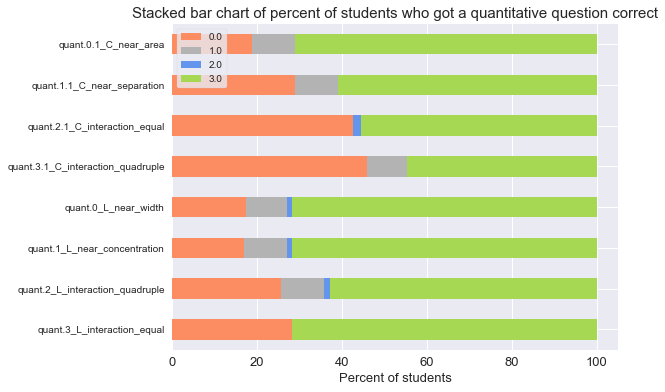

In [18]:
CMAP = ['#fc8d62','#b3b3b3','cornflowerblue','#a6d854','#e78ac3','#66c2a5','#ffd92f']
matplotlib.rcParams['axes.color_cycle'] = CMAP
quant_scores_ordinal[quant_score_columns].apply(lambda x: x.value_counts()).transpose().iloc[::-1,:].plot.barh(stacked=True)
ax = plt.subplot()
ax.legend(loc=2,frameon=True);ax.set_xlabel('Percent of students',fontsize=13)
ax.set_xticklabels([0,20,40,60,80,100],fontsize=13)
ax.set_xticks([round(int(x)*148.0/100.0,1) for x in [0,20,40,60,80,100]])
ax.set_title("Stacked bar chart of percent of students who got a quantitative question correct",fontsize=15);

### Flooring values
We want to see if students demonstrative understanding. We convert partial marks to zero and convert scores to binary.

In [19]:
quant_scores = quant_scores_ordinal.copy()
quant_scores.replace(1,0, inplace=True)
quant_scores.replace(2,0, inplace=True)
quant_scores.replace(3,1, inplace=True)
quant_scores.head()

,quant.0.1_C_near_area,quant.1.1_C_near_separation,quant.2.1_C_interaction_equal,quant.3.1_C_interaction_quadruple,quant.0_L_near_width,quant.1_L_near_concentration,quant.2_L_interaction_quadruple,quant.3_L_interaction_equal,sid,activity order
sid,,,,,,,,,,
77047160,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,77047160,LC
90447168,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,90447168,LC
24511163,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,24511163,LC
27451164,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,27451164,LC
46792161,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,46792161,LC


### Correlation between question pairs

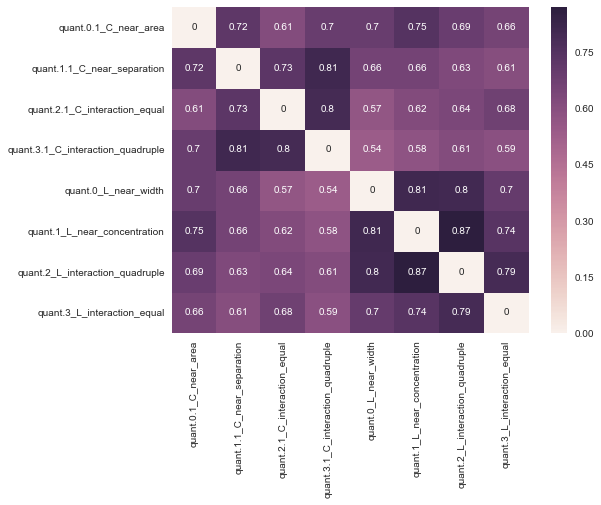

In [20]:
from scipy.stats import spearmanr
from sklearn.metrics import jaccard_similarity_score
correlation_matrix = np.zeros((len(quant_score_columns),len(quant_score_columns)))
for i,quant_scores_i in enumerate(quant_score_columns):
    for j,quant_scores_j in enumerate(quant_score_columns):
        jc = jaccard_similarity_score(list(quant_scores[quant_scores_i].dropna().astype(int)),list(quant_scores[quant_scores_j].dropna().astype(int)))
        correlation_matrix[i,j] = jc
#         print att_i,att_j,r,p

np.fill_diagonal(correlation_matrix,0)
# correlation_matrix[(correlation_matrix<0.4)&(correlation_matrix>-0.4)] = 0
sns.heatmap(correlation_matrix,yticklabels=quant_score_columns,xticklabels=quant_score_columns,annot=True);

Seems like there is much higher correlation between questions of the same sim than accross sims.

### Reliability

In [21]:
t = [['questions combined','reliability score']]
t.append(['all (8)',cronbach_alpha(quant_scores[quant_score_columns]) ])
t.append(['variables absorbance (4)', cronbach_alpha(quant_scores[['quant.0.1_C_near_area','quant.1.1_C_near_separation','quant.2.1_C_interaction_equal','quant.3.1_C_interaction_quadruple']]) ])
t.append(['variables capacitance (4)', cronbach_alpha(quant_scores[['quant.0_L_near_width','quant.1_L_near_concentration','quant.2_L_interaction_quadruple','quant.3_L_interaction_equal']]) ])
t.append(['near variables (4)', cronbach_alpha(quant_scores[['quant.0.1_C_near_area','quant.1.1_C_near_separation','quant.0_L_near_width','quant.1_L_near_concentration']]) ])
t.append(['interactions (4)', cronbach_alpha(quant_scores[['quant.2_L_interaction_quadruple','quant.3_L_interaction_equal','quant.2.1_C_interaction_equal','quant.3.1_C_interaction_quadruple']]) ])
print tabulate(t)

-------------------------  -----------------
questions combined         reliability score
all (8)                    0.81
variables absorbance (4)   0.78
variables capacitance (4)  0.8
near variables (4)         0.68
interactions (4)           0.71
-------------------------  -----------------


## Comparing scores by order

### qualitative scores

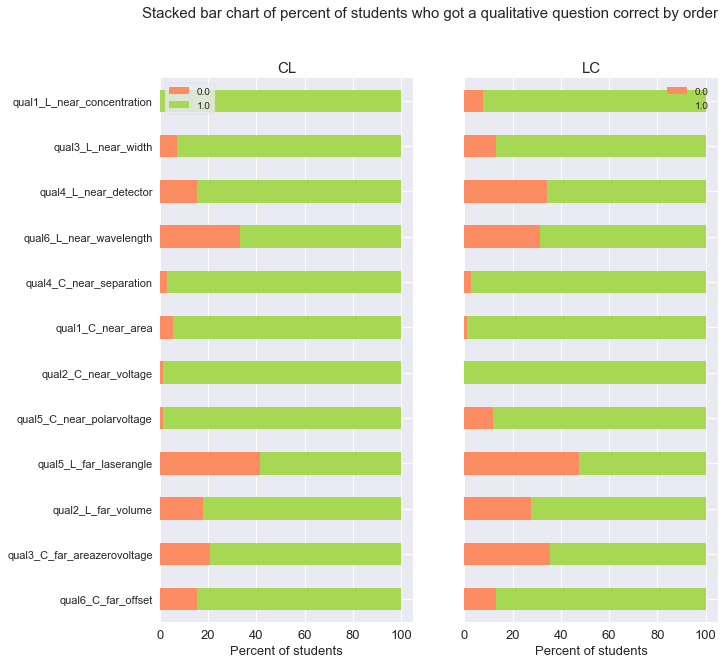

In [22]:
CMAP = ['#fc8d62','#a6d854','#e78ac3','#66c2a5','#ffd92f']
matplotlib.rcParams['axes.color_cycle'] = CMAP
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
for ax,order in zip(axes,['CL','LC']):
    N=qual_scores[qual_scores['activity order']==order].shape[0]
    qual_scores[qual_scores['activity order']==order][qual_score_columns].apply(lambda x: x.value_counts()).transpose().iloc[::-1,:].plot.barh(stacked=True,ax=ax)
    ax.set_xticks([round(int(x)*N/100.0,1) for x in [0,20,40,60,80,100]])
    ax.set_xticklabels([0,20,40,60,80,100],fontsize=13)
    ylabels = ax.get_yticklabels()
    ax.set_yticklabels([])
    ax.set_title(order,fontsize=15);
    ax.set_xlabel('Percent of students',fontsize=13)
    
axes[0].set_yticklabels(ylabels, fontsize=11)
axes[0].legend(loc=2,frameon=True)
fig.suptitle('Stacked bar chart of percent of students who got a qualitative question correct by order',fontsize=15)

### Quantitative scores

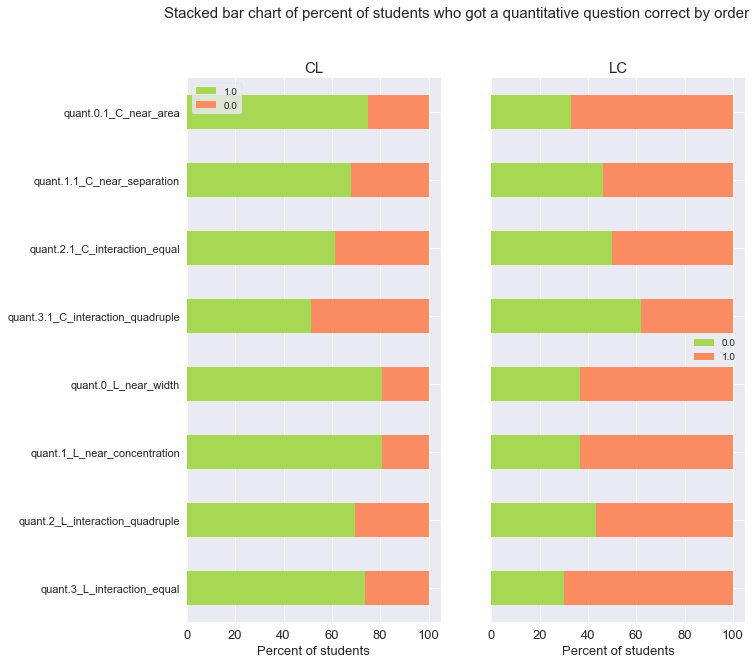

In [23]:
CMAP = ['#a6d854','#fc8d62','#e78ac3','#66c2a5','#ffd92f']
matplotlib.rcParams['axes.color_cycle'] = CMAP
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,10))

for ax,order in zip(axes,['CL','LC']):
    N=quant_scores[quant_scores['activity order']==order].shape[0]
    quant_scores[quant_scores['activity order']==order][quant_score_columns].apply(lambda x: x.value_counts()).transpose().iloc[::-1,:].plot.barh(stacked=True,ax=ax)
    ax.set_xticks([round(int(x)*N/100.0,1) for x in [0,20,40,60,80,100]])
    ax.set_xticklabels([0,20,40,60,80,100],fontsize=13)
    ylabels = ax.get_yticklabels()
    ax.set_yticklabels([])
    ax.set_title(order,fontsize=15);
    ax.set_xlabel('Percent of students',fontsize=13)
    
axes[0].set_yticklabels(ylabels, fontsize=11)
axes[0].legend(loc=2,frameon=True)
fig.suptitle('Stacked bar chart of percent of students who got a quantitative question correct by order',fontsize=15)